In [10]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#모델링 모듈
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, average_precision_score, confusion_matrix
import shap
from imblearn.over_sampling import SMOTE

#1. data_load
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
data = pd.read_csv('Churn_Modelling.csv',index_col=0)

#2. data_preprocessing
# missing D(4개 행 제거)
data.isnull().sum()
nan_data = data.dropna()
print('결측 처리 :' ,nan_data.shape)

# duplicated D(2행 제거)
nan_data[nan_data.duplicated()]
new_data = nan_data[~nan_data.duplicated()]
print('중복 처리 :',new_data.shape)

#encoding : gender-label ( Female = 0, male = 1) /  geography-onehot
le = LabelEncoder()
new_data['Gender'] = le.fit_transform(new_data["Gender"])

oe = OneHotEncoder()
oe.fit(new_data[['Geography']])
geo_csr = oe.transform(new_data[['Geography']])
csr_df = pd.DataFrame(geo_csr.toarray(), columns = oe.get_feature_names_out())
df = new_data.reset_index(drop=True)  # df 인덱스 초기화
csr_df = csr_df.reset_index(drop=True)  # csr_df 인덱스 초기화
inco_df = pd.concat([df,csr_df],axis=1)

#check
int_data = inco_df.drop(columns=['CustomerId', 'Surname','Geography'])
X = int_data.drop("Exited", axis=1)
y_true = int_data['Exited']
print('전처리 완료:',X.shape,y_true.shape)
print('----------------------------')

#4.data engineering
#tester split
X_train, X_test, y_train, y_test = train_test_split(X,y_true,stratify = y_true,test_size = 0.2, random_state= 42)
print('데이터 분리 후 크기 : ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#minmaxscaling - 적용유무 검토 
target_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

mn_sc = MinMaxScaler()
X_train_sc[target_features] = mn_sc.fit_transform(X_train[target_features])
X_test_sc[target_features] = mn_sc.transform(X_test[target_features]) #테스터는 정규화 학습 안함 

#Over Sampling
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_sc, y_train)
print("SMOTE 적용 후 데이터 크기:", X_train_res.shape, y_train_res.shape)
print(f'original : {y_train.value_counts()}')
print(f'smote : {y_train_res.value_counts()}')

print('----------------------------')

결측 처리 : (9998, 13)
중복 처리 : (9996, 13)
전처리 완료: (9996, 12) (9996,)
----------------------------
데이터 분리 후 크기 :  (7996, 12) (2000, 12) (7996,) (2000,)
SMOTE 적용 후 데이터 크기: (12734, 12) (12734,)
original : Exited
0    6367
1    1629
Name: count, dtype: int64
smote : Exited
0    6367
1    6367
Name: count, dtype: int64
----------------------------


In [7]:
# SVM 모델
import sklearn.svm
clf = sklearn.svm.SVC(kernel='rbf',random_state=42)

clf.fit(X_train_res, y_train_res)

y_pred_svc = clf.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_svc))
print("f1-score : ", f1_score(y_test, y_pred_svc))
print("recall : ", recall_score(y_test, y_pred_svc))
print("예측도 : ", precision_score(y_test, y_pred_svc))
print("AUC :", average_precision_score(y_test, y_pred_svc))

정확도 :  0.739
f1-score :  0.5347593582887701
recall :  0.7352941176470589
예측도 :  0.42016806722689076
AUC : 0.36294710825506676


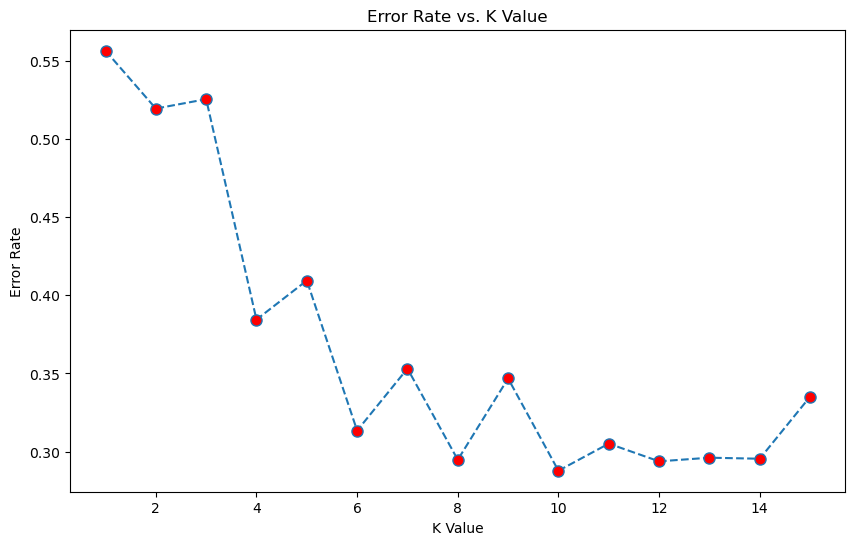

In [61]:
# KNN 모델, 추가 전처리 없을 시 K=14에서 에러율 제일 작음
error_rate = []

for i in range(1, 16):
    knn_i = KNeighborsClassifier(n_neighbors=i)
    knn_i.fit(X_train_res, y_train_res)
    y_pred_i = knn_i.predict(X_test)
    error_rate.append(np.mean(y_pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), error_rate, marker='o', linestyle='dashed', markersize=8, markerfacecolor='red')
plt.title("Error Rate vs. K Value")
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.show()

In [8]:
k = 4
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_knn))
print("f1-score : ", f1_score(y_test, y_pred_knn))
print("recall : ", recall_score(y_test, y_pred_knn))
print("예측도 : ", precision_score(y_test, y_pred_knn))
print("AUC :", average_precision_score(y_test, y_pred_knn))


정확도 :  0.751
f1-score :  0.4328018223234624
recall :  0.46568627450980393
예측도 :  0.40425531914893614
AUC : 0.2972561535252399


In [10]:
# 각 모델 정확도를 제외한 모든 수치가 낮아 실사용 불가, optuna를 이용한 튜닝 수행
import optuna
import itertools
import sklearn.svm
import sklearn.model_selection
from sklearn.metrics import classification_report

In [75]:
# SVC optuna 수행
def objective(trial):

    svc_c = trial.suggest_float("C", 0.001, 1000, log=True)
    classifier_obj = sklearn.svm.SVC(C=svc_c, gamma="auto", random_state=42)

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_train_res, y_train_res, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-31 19:56:02,993] A new study created in memory with name: no-name-25931663-3140-45fc-b188-8dab9a111484
[I 2025-01-31 19:56:05,619] Trial 0 finished with value: 0.8201400107700593 and parameters: {'C': 222.25874799096732}. Best is trial 0 with value: 0.8201400107700593.
[I 2025-01-31 19:56:08,143] Trial 1 finished with value: 0.7249147370310537 and parameters: {'C': 0.10576081869212717}. Best is trial 0 with value: 0.8201400107700593.
[I 2025-01-31 19:56:10,815] Trial 2 finished with value: 0.6739364566505116 and parameters: {'C': 0.031080419634489737}. Best is trial 0 with value: 0.8201400107700593.
[I 2025-01-31 19:56:13,085] Trial 3 finished with value: 0.7337102854065698 and parameters: {'C': 0.16885870202250378}. Best is trial 0 with value: 0.8201400107700593.
[I 2025-01-31 19:56:18,028] Trial 4 finished with value: 0.8278585532220427 and parameters: {'C': 775.866972942395}. Best is trial 4 with value: 0.8278585532220427.
[I 2025-01-31 19:56:19,786] Trial 5 finished with

Number of finished trials: 100
Best trial:
  Value: 0.8285765571710645
  Params: 
    C: 991.9788157685106


In [6]:
# 최적화된 하이퍼파라미터로 튜닝

svc_c = study.best_params['C']
model = sklearn.svm.SVC(C=svc_c, gamma="auto", random_state=42)
model.fit(X_train_res, y_train_res)

y_pred_svc_op = model.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_svc_op))
print("f1-score : ", f1_score(y_test, y_pred_svc_op))
print("recall : ", recall_score(y_test, y_pred_svc_op))
print("예측도 : ", precision_score(y_test, y_pred_svc_op))
print("AUC :", average_precision_score(y_test, y_pred_svc_op))

NameError: name 'study' is not defined

In [70]:
# KNN 최적화, 목적함수 정의
from sklearn.model_selection import cross_val_score

def obj_knn(trial,x,y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
    score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
    f1_macro = np.mean(score)

    return f1_macro

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: obj_knn(trial, X_train_res, y_train_res), n_trials = 100)

# 최적 파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적 파라미터로 모델 학습
best_params = study.best_trial.params
knn_model = KNeighborsClassifier(**best_params)

[I 2025-01-31 19:52:15,687] A new study created in memory with name: no-name-327a000e-2fdd-40ee-ab6b-d672004b3daa
[I 2025-01-31 19:52:15,887] Trial 0 finished with value: 0.787216991913261 and parameters: {'n_neighbors': 12, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.787216991913261.
[I 2025-01-31 19:52:15,992] Trial 1 finished with value: 0.8713623911643342 and parameters: {'n_neighbors': 2, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,105] Trial 2 finished with value: 0.8132242792074651 and parameters: {'n_neighbors': 25, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,209] Trial 3 finished with value: 0.8372735375874905 and parameters: {'n_neighbors': 13, 'metric': 'manhattan', 'weights': 'distance'}. Best is trial 1 with value: 0.8713623911643342.
[I 2025-01-31 19:52:16,349] Trial 4 finished with value: 0.778

Best trial:
  Value: 0.8735201058347499
  Params: 
    n_neighbors: 1
    metric: manhattan
    weights: distance


In [ ]:
# bset parmeter training
knn_model.fit(X_train_res,y_train_res)
y_pred_knn_op = knn_model.predict(X_test_sc)

print("정확도 : ", accuracy_score(y_test, y_pred_knn_op))
print("f1-score : ", f1_score(y_test, y_pred_knn_op))
print("recall : ", recall_score(y_test, y_pred_knn_op))
print("예측도 : ", precision_score(y_test, y_pred_knn_op))
print("AUC :", average_precision_score(y_test, y_pred_knn_op))


정확도 :  0.6948982994331444
f1-score :  0.3728581220013708
recall :  0.4451718494271686
예측도 :  0.32075471698113206


In [81]:
# 모델과 하이퍼파라미터 범위 정의
param_grids = {    
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'SVM': {
        'model': svm.SVC(random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 25, 50, 100, 500],
            'kernel': ['linear', 'rbf', 'poly', 'sigmod'],
            'gamma': ['auto', 'scale']
        }
    },             
}

# 결과를 저장
results = {}

In [82]:
# 각 모델별 학습 및 평가
from sklearn.model_selection import cross_val_score, GridSearchCV
for name, model_info in param_grids.items():
    print(f"\n{name} 모델 학습 중...")

    # GridSearchCV를 통한 하이퍼파라미터 튜닝
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    # 모델 학습
    grid_search.fit(X_train_res, y_train_res)

    # 5-fold cv
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train_res, y_train_res, cv=5)

    # prediction
    y_pred = grid_search.predict(X_test_sc)

    # 평가 지표 계산
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_scores_mean': cv_scores.mean(),
        'cv_scores_std': cv_scores.std(),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'avg_precision': average_precision_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }




KNN 모델 학습 중...

SVM 모델 학습 중...


In [83]:
# 결과 출력
for name, result in results.items():
    print(f"\n=== {name} 모델 결과 ===")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best CV Score: {result['best_score']:.4f}")
    print(f"5-fold CV Score: {result['cv_scores_mean']:.4f} (+/- {result['cv_scores_std'] * 2:.4f})")
    print(f"Test Accuracy: {result['accuracy']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Average Precision: {result['avg_precision']:.4f}")
    print("\nConfusion Matrix:")
    print(result['confusion_matrix'])


=== KNN 모델 결과 ===
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best CV Score: 0.8686
5-fold CV Score: 0.8686 (+/- 0.0105)
Test Accuracy: 0.7446
F1 Score: 0.4284
Recall: 0.4697
Precision: 0.3937
Average Precision: 0.2930

Confusion Matrix:
[[1946  442]
 [ 324  287]]

=== SVM 모델 결과 ===
Best Parameters: {'C': 500, 'gamma': 'auto', 'kernel': 'rbf'}
Best CV Score: 0.8280
5-fold CV Score: 0.8280 (+/- 0.0473)
Test Accuracy: 0.7829
F1 Score: 0.5526
Recall: 0.6579
Precision: 0.4763
Average Precision: 0.3831

Confusion Matrix:
[[1946  442]
 [ 209  402]]


In [84]:
# Optuna 함수 정의
def objective(trial):
    # 하이퍼파라미터 범위 설정
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
    l2_leaf_reg = trial.suggest_loguniform("l2_leaf_reg", 1e-3, 10.0)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)

    # 모델 생성
    cb =  CatBoostClassifier(
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        verbose=False
    )

    # 교차 검증을 통한 성능 평가
    score = cross_val_score(cb, X_train_res, y_train_res, cv=5, scoring="accuracy")
    ac = score.mean()

    return ac

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # n_trials는 시도 횟수, timeout 둘중 빨리 끝나는 대로 종료 => 너무 오래걸린다,,,,,

## 4. 최적의 하이퍼파라미터 출력
trial = study.best_trial
print("Value:", trial.value)
print("Params:", trial.params)

[I 2025-01-31 21:01:14,085] A new study created in memory with name: no-name-c82d4749-15d2-4ca4-9615-fb0e4bb11a5f
[I 2025-01-31 21:01:15,337] Trial 0 finished with value: 0.7926799741936108 and parameters: {'learning_rate': 0.01804196503142357, 'l2_leaf_reg': 0.36901715976899263, 'n_estimators': 199, 'max_depth': 3}. Best is trial 0 with value: 0.7926799741936108.
[I 2025-01-31 21:01:16,843] Trial 1 finished with value: 0.8140408423965791 and parameters: {'learning_rate': 0.020086278172364188, 'l2_leaf_reg': 1.0390066489781091, 'n_estimators': 168, 'max_depth': 6}. Best is trial 1 with value: 0.8140408423965791.
[I 2025-01-31 21:01:21,102] Trial 2 finished with value: 0.8789373067440536 and parameters: {'learning_rate': 0.029330101864374368, 'l2_leaf_reg': 0.004647930030185598, 'n_estimators': 346, 'max_depth': 6}. Best is trial 2 with value: 0.8789373067440536.
[I 2025-01-31 21:01:28,546] Trial 3 finished with value: 0.8928497212764981 and parameters: {'learning_rate': 0.0476701846542

Value: 0.9003903176102833
Params: {'learning_rate': 0.05848683268135783, 'l2_leaf_reg': 0.01324402123523703, 'n_estimators': 399, 'max_depth': 9}


피쳐 중요도:
	[0.01 0.01 0.39 0.01 0.12 0.28 0.   0.12 0.01 0.   0.05 0.  ]
CreditScore: 0.014
Gender: 0.009
Age: 0.386
Tenure: 0.006
Balance: 0.117
NumOfProducts: 0.283
HasCrCard: 0.000
IsActiveMember: 0.119
EstimatedSalary: 0.012
Geography_France: 0.000
Geography_Germany: 0.054
Geography_Spain: 0.000


<Axes: >

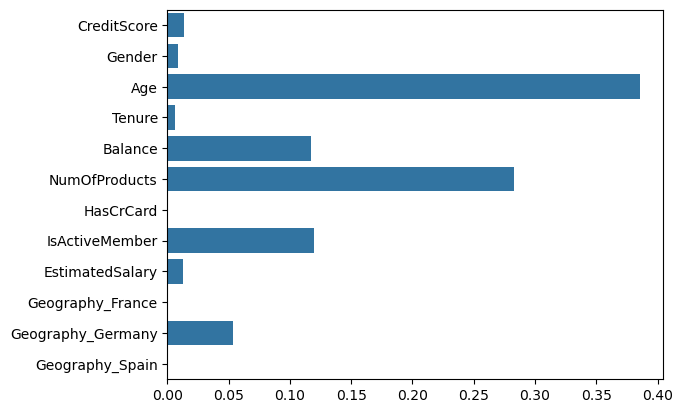

In [17]:
# Decision Tree 최적 모델에 대한 피처 임포턴스 확인, 스케일링 전 데이터 활용

from sklearn import tree

clf_dt = tree.DecisionTreeClassifier(random_state=42,
        max_depth=7,
        min_samples_split=38,
        min_samples_leaf=15,
        criterion='gini')

clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)

print("피쳐 중요도:\n\t{0}".format(np.round(clf_dt.feature_importances_, 2)))

for name, value in zip(X.columns.tolist(), clf_dt.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

sns.barplot(x=clf_dt.feature_importances_, y=X.columns.tolist())

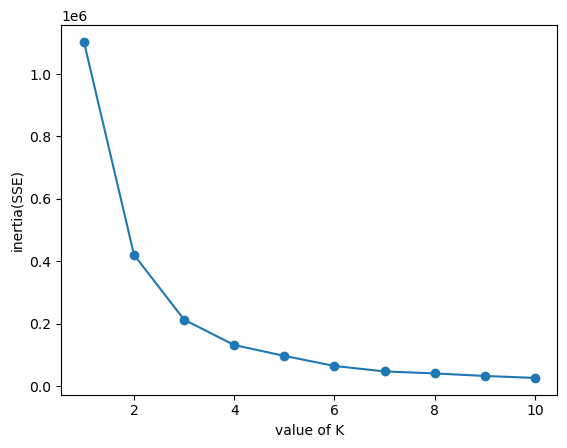

In [33]:
# Age, NumOfProducts 변수 기준으로 K-Means clustring 진행
from sklearn.cluster import KMeans

X_cluster = df[['Age', 'NumOfProducts']]

# 각 K값에 대한 오차제곱합 계산 및 시각화
SSE = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    SSE.append(kmeans.inertia_)

plt.plot(range(1,11), SSE, marker='o')
plt.xlabel('value of K')
plt.ylabel('inertia(SSE)')
plt.show()

In [34]:
# 경사가 가장 완만해지는 K값 = 3로 사용, 2번 그룹이 이탈률이 상대적으로 높음
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)
df[['Age', 'NumOfProducts', 'Cluster']].head()

cluster_analysis = df.groupby('Cluster')['Exited'].mean()
print(cluster_analysis)

Cluster
0    0.090838
1    0.295090
2    0.416346
Name: Exited, dtype: float64


In [35]:
cluster_summery = df.groupby('Cluster').mean(numeric_only=True)
cluster_summery

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Cluster,,,,,,,,,,,
0,1.569080e+07,651.107354,0.562328,31.204046,5.034212,74663.648260,1.545026,0.712741,0.510224,99784.613447,0.090838
1,1.569077e+07,649.922222,0.532300,43.048902,5.003359,78072.302943,1.523773,0.696641,0.471835,101509.822217,0.295090
2,1.569233e+07,649.711538,0.513462,61.300000,4.948077,79401.538144,1.481731,0.702885,0.698077,96460.605490,0.416346


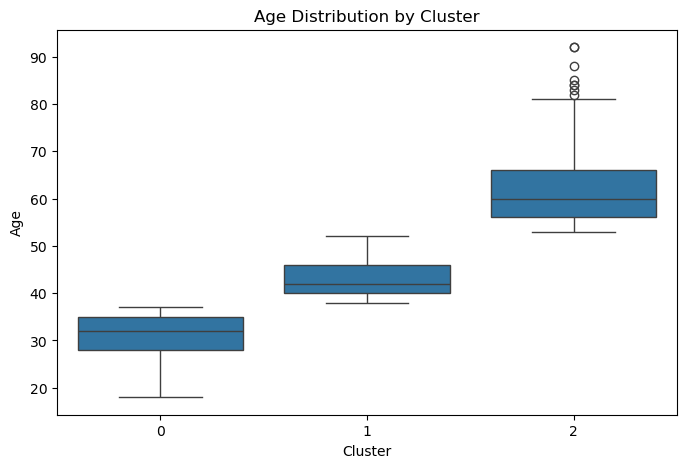

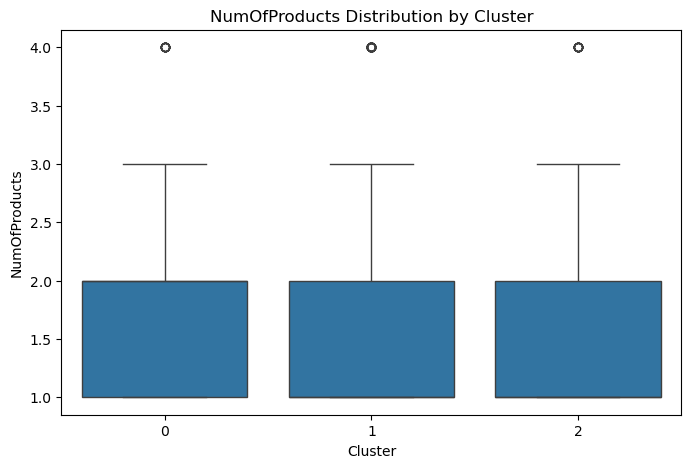

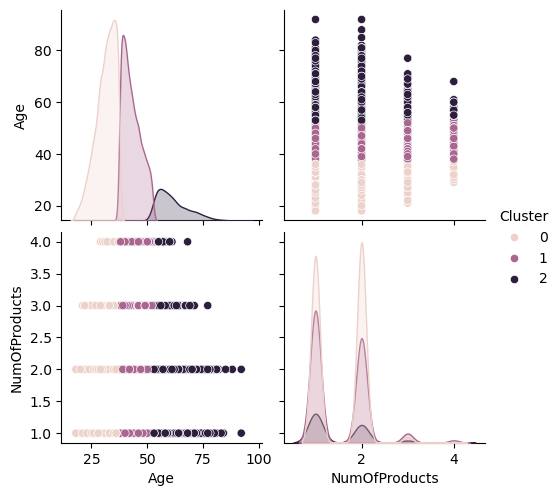

In [36]:
# 클러스터별 Age 분포
plt.figure(figsize=(8, 5))
sns.boxplot(x="Cluster", y="Age", data=df)
plt.title("Age Distribution by Cluster")
plt.show()

# 클러스터별 NumOfProducts 분포
plt.figure(figsize=(8, 5))
sns.boxplot(x="Cluster", y="NumOfProducts", data=df)
plt.title("NumOfProducts Distribution by Cluster")
plt.show()

sns.pairplot(df, hue="Cluster", vars=["Age", "NumOfProducts"])
plt.show()